**This notebook follows the tutorial, with some modifications to allow multiple images as style reference**: https://towardsdatascience.com/how-to-get-beautiful-results-with-neural-style-transfer-75d0c05d6489

### Imports

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import math
import numpy
import matplotlib.pyplot as plt
!pip install kornia
from kornia.filters import GaussianBlur2d as GaussianBlur

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
kornia.filters.GaussianBlur2d?

Object `kornia.filters.GaussianBlur2d` not found.


### Image processing

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None, ax=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax:
      ax.imshow(image)
    else:
      plt.imshow(image)
      if title is not None:
          plt.title(title)
      plt.pause(0.001) # pause a bit so that plots are updated

### Pytorch implementation of tv loss (to penalize noise)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

### Define image distance and style distance

In [0]:
# image distance

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        tv_loss = TVLoss()
        self.loss = F.l1_loss(input, self.target) + tv_loss(input)
        global loss_count
        loss_count['content'].append(self.loss.item())
        #smoothing = GaussianSmoothing(128, 50, 1)
        #self.loss = F.l1_loss(smoothing(input), smoothing(self.target)) #+ tv_loss(input
        return input

In [0]:
# style distance

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class Multiple_StyleLoss(nn.Module):

    def __init__(self, target_features):
        super(Multiple_StyleLoss, self).__init__()
        self.target = []
        for target_feature in target_features:
            self.target.append(gram_matrix(target_feature).detach())

    def forward(self, input):
        G = gram_matrix(input)
        losses = []
        global loss_count
        for i,target in enumerate(self.target):
            target_loss = F.mse_loss(G, target)
            loss_count[i].append(target_loss.item())
            losses.append(target_loss)
        #self.loss = min(losses)  #keep the loss that is closest !
        self.loss = sum([loss*max(10**-10,torch.exp(-loss*10**5)) for loss in losses])/sum([max(10**-10,torch.exp(-loss*10**5)) for loss in losses])#Exponentially weighted average

        return input

### Load vgg19 and modify it

In [9]:
# loading the model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# vgg19 is trained with the following normalizations

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
# modify vgg19

# desired depth layers to compute style/content losses :
# this means here that conv_4 is the layer that does the content loss, and we will trim all layers after this one
content_layers_default = ['conv_4']
style_layers_default =  ['conv_1', 'conv_2','conv_3', 'conv_4', 'conv_5'] #'conv_1', 'conv_2' were also added in the pytorch implementation

def get_multiple_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_imgs, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            #smoothing = GaussianSmoothing(3, 20, 1)
            target = model(content_img).detach() #smoothing(
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_features = []
            for style_img in style_imgs:
                target_features.append(model(style_img).detach())
            style_loss = Multiple_StyleLoss(target_features)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], Multiple_StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### Gradient descent

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    #optimizer = optim.Adam([input_img.requires_grad_()], lr = 0.1)
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

### Define optimization routine

In [0]:
def run_multiple_style_transfer(cnn, normalization_mean, normalization_std,
                       content_imgs, style_img, input_img, num_steps=300,
                       style_weight=1000000, abstract=1, content_weight=1,show_images=False):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_multiple_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_imgs)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward(retain_graph=True) #retain_graph=True if we want to add gradients
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

                if run[0] % 100 == 0 and show_images:
                    plt.figure()
                    current_img = input_img.data.clamp_(0, 1)
                    imshow(current_img, title='Output Image')
                    plt.show();

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### Run algorithm

In [0]:
def crop(style_img,content_img):

  if style_img.size() != content_img.size():
      content_img = content_img[:1,:3,:512,:512]
      style_img = style_img[:1,:3,:512,:512]
      try:
        style_img = style_img[:content_img.size()[0],:content_img.size()[1],
                              :content_img.size()[2],:content_img.size()[3]]
      except:
        print("Error: style img smaller than content img")
        #content_img = content_img[:style_img.size()[0],:style_img.size()[1],
        #                      :style_img.size()[2],:style_img.size()[3]] 
      #print("Now",style_img.size(),content_img.size())
  return style_img, content_img  

def execute_multiple(style_imgs,content_img,**args):

  # image plots
  if args['show_images']:
    nb_imgs = len(style_imgs)
    if len(style_imgs)>1:
      fig, axs = plt.subplots(1,nb_imgs, figsize=(nb_imgs*7,6))

    for i in range(nb_imgs):
      style_imgs[i],content_img = crop(style_imgs[i],content_img)
      if len(style_imgs)>1:
        imshow(style_imgs[i], ax=axs[i])
        fig.show()
      else:
        imshow(style_imgs[i])

    # input input that we need to keep to compute image dist loss
    plt.figure()
    imshow(content_img, title='Content Image')
  #smoothing = GaussianSmoothing(3, 20, 1)
  if abstract:
    gauss = GaussianBlur((abstract*2 + 1, abstract*2 + 1), (10, 10))
    # blur the image
    #content_img += torch.randn(content_img.data.size(), device=device)*abstract/10.
    content_img = gauss(content_img)

  input_img = content_img.clone() 

  output = run_multiple_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                              content_img, style_imgs, input_img, **args)

  plt.figure()
  imshow(output, title='Output Image')

  # sphinx_gallery_thumbnail_number = 4
  plt.ioff()
  plt.show()

  return output
  

### Tests

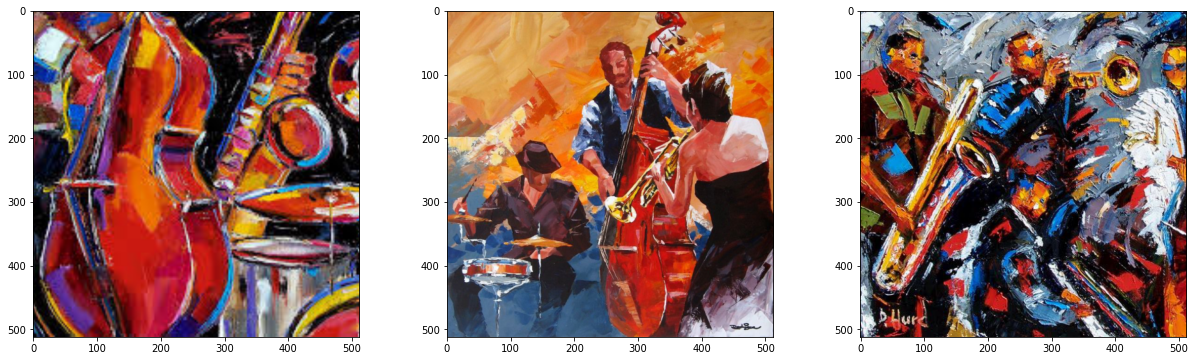

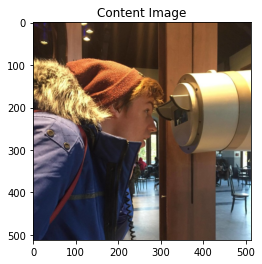

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 6315.107422 Content Loss: 122.566765

run [100]:
Style Loss : 6180.752930 Content Loss: 114.930191



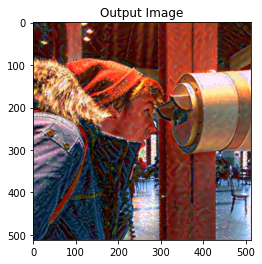

run [150]:
Style Loss : 6148.798828 Content Loss: 111.970345

run [200]:
Style Loss : 6135.023438 Content Loss: 110.055618



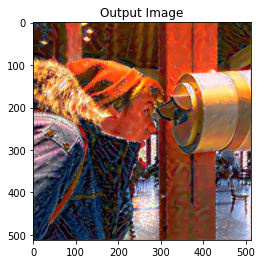

run [250]:
Style Loss : 6127.363770 Content Loss: 108.456261

run [300]:
Style Loss : 6123.437500 Content Loss: 107.343216



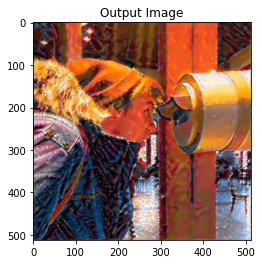

run [350]:
Style Loss : 6120.976074 Content Loss: 106.664375

run [400]:
Style Loss : 6119.598633 Content Loss: 106.249306



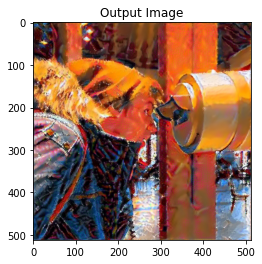

run [450]:
Style Loss : 6119.084473 Content Loss: 106.219009

run [500]:
Style Loss : 6125.159668 Content Loss: 109.464607



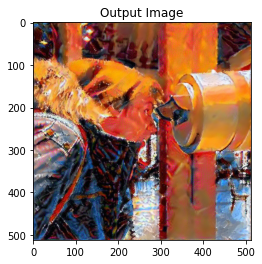

run [550]:
Style Loss : 6117.672852 Content Loss: 105.548088

run [600]:
Style Loss : 6117.114746 Content Loss: 105.183434



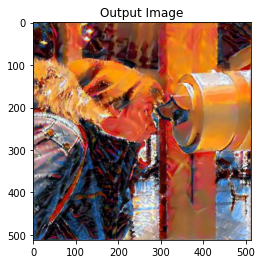

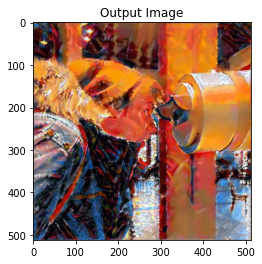

In [48]:
import numpy as np

# Van Gogh
style_img1 = image_loader("j1.jpeg")
style_img2 = image_loader("j2.jpg")
style_img3 = image_loader("j3.jpg")
style_img4 = image_loader("j4.jpg")
style_img5 = image_loader("j5.jpg")

style_imgs = [style_img3, #style_img1,style_img2,
              style_img4,style_img5] 

#style_imgs = [style_img1]

loss_count = {}
loss_count['content']=[]
for i in range(len(style_imgs)):
  loss_count[i]=[]

content_img = image_loader("pdp.png")
abstract = 1 #How abstract from 1 to 10

execute_multiple(style_imgs,content_img,abstract=abstract,num_steps=600,content_weight=1.3,show_images=True); #300 steps is enough with Adam

dict_keys(['content', 0, 1, 2])


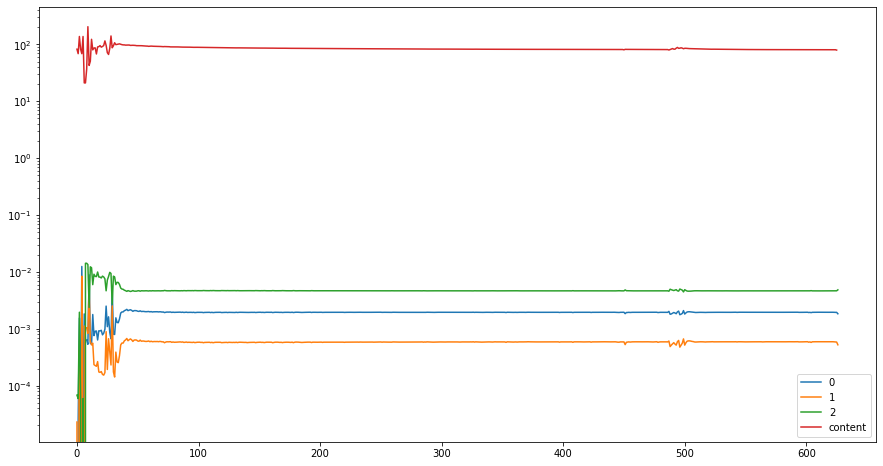

In [49]:
plt.figure(figsize=(15,8))
print(loss_count.keys())
for i in range(len(style_imgs)):
  plt.semilogy(loss_count[i][::5]*10**0,label=str(i))
plt.semilogy(loss_count['content'],label='content')
plt.legend()

dict_keys(['content', 0, 1, 2])


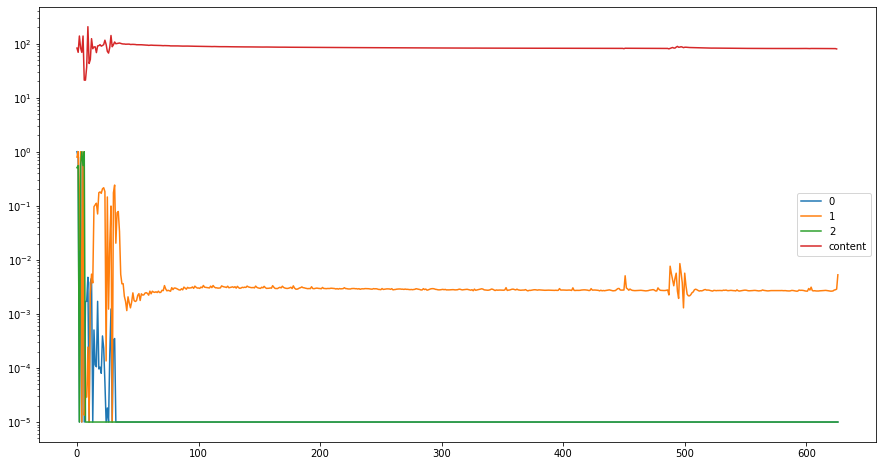

In [50]:
plt.figure(figsize=(15,8))
print(loss_count.keys())
for i in range(len(style_imgs)):
  plt.semilogy([max(10**-5,np.exp(-target_loss*10**4)) for target_loss in loss_count[i][::5]],label=str(i))
plt.semilogy(loss_count['content'],label='content')
plt.legend()

In [0]:
# Gauguin
if True:
  break

print(anansdlk)
style_img1 = image_loader("vg1.jpg")
style_img2 = image_loader("vg2.jpg")
style_img3 = image_loader("vg3.jpg")
style_img4 = image_loader("vg4.jpg")
style_img5 = image_loader("vg5.jpg")
style_img6 = image_loader("vg6.jpg")


style_imgs = [style_img1,style_img2,style_img3,style_img4,style_img5,style_img6] 
content_img = image_loader("roux_barbu.jpg")

import numpy as np

ims = {}
nb_style=4
nb_cont=10
style_w=20

for j,content_w in enumerate(np.linspace(1,1.5,nb_cont)):
      print(style_w,content_w)
      im = execute_multiple(style_imgs,content_img,num_steps=200,
                            content_weight=content_w,style_weight=style_w*1000000)
      # extract image
      image = im.cpu().clone()  # we clone the tensor to not do changes on it
      image = image.squeeze(0)      # remove the fake batch dimension
      image = unloader(image)
      ims[str(style_w) + '_' + str(content_w)] = image

fig,axs = plt.subplots(nb_style,nb_cont,figsize=(nb_cont*5,nb_style*5))
for i,style_w in enumerate(np.linspace(1,20,nb_style)):
    for j,content_w in enumerate(np.linspace(0.2,2,nb_cont)):
      axs[i,j].imshow(ims[str(style_w) + '_' + str(content_w)])
      axs[i,j].set_title(str(style_w) + '_' + str(content_w))
fig.show();